In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import os
from os import path
import tarfile
import pandas as pd
from shutil import copyfile
import tensorflow as tf
from PIL import Image
import shutil
!pip install opencv-python==3.4.2.17
#!pip install opencv_contrib_python==3.4.2.17 --force-reinstall
import cv2 
from skimage.io import imread, imshow
from skimage.filters import prewitt_h,prewitt_v
import matplotlib.pyplot as plt

from tensorflow.keras.applications import mobilenet_v2
from keras.preprocessing import image as kimage

     |████████████████████████████████| 25.0MB 38.0MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### **_BREAST CANCER DETECTION_**

#### **PROJECT GOALS AND DECRIPTION**
We desire to create a **Content Based Image Retrieval** and a **classification system** for images given by ***mammography***. Indeed, this system will be helpful to the radiologist in order to make her/his diagnosis more accurate. 

Mammography is an exam made by women to examine their breast and prevent cancer. This exam conceives the usage of low-energy X-rays for catching the characteristics of breast tissue. Especially, the breast is compressed using a plate in order to both reduce the scattering and the amount of rays and avoid blurr. There are two types of mammography: the screening and the diagnostic ones. The former is conceived to explore the presence of the cancer, while the latter goes in if there is any suspect. We analyze the first one which is characterized by the acquisition of four images for each patient: for each breast, there are two images corrisponding to two views, i.e. the craniocaudal (head-to-foot view) and the mediolateral oblique (angled side-view).  Moreover, addictional information are given such as the age of patient, the breast density (an index which corresponds to the amount of fibrous and glandular tissue) and, if there is a cancer, a ***countour defining the critical zone*** etc. 

#### ***DATASET***

The dataset **Digital Database for Screening Mammography (DDSM)** contains those images for a sample of patients. The dataset was downloaded from Kaggle (https://www.kaggle.com/cheddad/miniddsm2) and not from the original source (http://www.eng.usf.edu/cvprg/Mammography/Database.html). Infact, the latter contains images with `ljpeg format`, it doesn't provide a suitable format for the download and the size is larger than 200 GB. On the other hand, the kaggle dataset is designed to give an easier access to the user and its size is 45GB. 

#### ***PREPROCESSING***

Images of patients are splitted into three different folders:
- normal
- benign
- malign

The first set represents images associated to patients that haven't cancer, while the other ones contain images of patients which have cancer (benign or malignant) in at least one of the two breasts. It's important to note that in the last cases, each image of breast with cancer, is associated to a line surrounding the suspicious zone, i.e. ***mask***. 

Resolution of images is high and therefore tiny details can be easily discovered. However, since we want to focus on the cancer zone, we must select a part of it. So, we decided to extract a part of the images using the mask (**focus images**). As a consequence, _we used only breast with the mask and delete the others_.

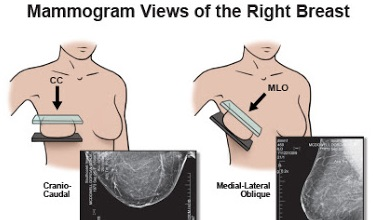

In [ ]:

def focus_region(row, plus):
  # Zoom the region defined by the mask.
  # Input:
  # row: each row of dataset 8apply function)
  # plus: surrounding of the focus, if you want to see more.
  # Output:
  # focus: portion of focused image.
  im = row['IMAGE']
  mask = row['MASK']
  # defin contour of image.
  _, contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  contours = np.array(contours)
  contours = contours[0]
  plus = plus
  # define the rectangle which contains the focused image.
  xmin = 0 if np.min(contours[:,0,0])-plus < 0 else np.min(contours[:,0,0])-plus
  xmax = 0 if np.max(contours[:,0,0])+plus < 0 else np.max(contours[:,0,0])+plus
  ymin = 0 if np.min(contours[:,0,1])-plus < 0 else np.min(contours[:,0,1])-plus
  ymax = 0 if np.max(contours[:,0,1])+plus < 0 else np.max(contours[:,0,1])+plus
  # subset the image.
  focus = im[ymin:ymax,xmin:xmax]

  return focus

def define_SIFT_desc(row):
  # Extract SIFT descriptor from image.
  # Input: row of the dataset (apply function).
  # Output: keypoints and descriptors.
  image = row['FOCUS_PLUS']
  sift = cv.xfeatures2d.SIFT_create()
  [kps1, features1] = sift.detectAndCompute(image, None)
  
  return kps1, features1


# This class aims to load images and trasform them into a dataframe.
class my_images:
  def __init__(self, root, img_name):
    # Input:
    # root: path of drive filesystem for our dataset.
    # img_name: list of fixed file names.
    self.base_path = root 
    self.img_name = img_name
  
  def identity(self, img):
    # Input:
    # img: images
    # Output:
    # The image will be flattened in order to fit input of NN.

    return kimage.img_to_array(img).flatten()

  def loader(self):
    # Description:
    # Load images and delete the ones without mask.
    
    image = []

    for i, d in enumerate(sorted(os.listdir(self.base_path))):
      type_path = self.base_path + str(d)
      for j, sd in  enumerate(sorted(os.listdir(type_path))):
        patient_path = type_path + '/' + sd
        ff = os.listdir(patient_path)[0][0]
        # print(ff)
        # save date in .ics file.
        with open(patient_path + '/' + ff + '-' + sd + '-1.ics', "r") as f:
          cal = f.readlines()
        # print(cal)
        # take only the breast images and check if the mask exists.
        list_file = [patient_path + '/' + ff + '_' + sd + file + '.png' for file in self.img_name]
        for each_img_path in list_file:
          splt = each_img_path.split('.')
          candidate = splt[0] + '.' + splt[1] + '_Mask' + '.' + splt[2]
          if os.path.exists(candidate):
            # convert_format(each_img_path), convert_format(candidate)
            splt_im = each_img_path.split('.')
            splt_mask = candidate.split('.')
            appo = splt_im[1].split('_')
           # print(sd, appo[0], appo[1], d)
            image.append({'CODE': sd,
                          'IMAGE': cv2.imread("".join(splt_im[0:-2]) + '.' + splt_im[-2] + '.png', 0),
                          'MASK': cv2.imread("".join(splt_mask[0:-2]) + '.' + splt_mask[-2] + '.png', 0),
                          'LEFT': 1 if appo[0] == 'LEFT' else 0,
                          'CC': 1 if appo[1] == 'CC' else 0,
                          'BENING': 1 if d[0] == 'B' else 0,
                          cal[4].split()[0]: cal[4].split()[1] if len(cal[4].split()) == 2 else 55, 
                          cal[7].split()[0]: cal[7].split()[1] if len(cal[7].split()) == 2 else 2})
          else:
            os.remove(each_img_path)
        
    return pd.DataFrame(image)

In [ ]:
# shutil.rmtree('./12-Datatset')

In [ ]:
# shutil.rmtree('./gdrive/MyDrive/DSIM/BenignFocus/')
# shutil.rmtree('./gdrive/MyDrive/DSIM/MalignFocus/')

In [ ]:
# os.mkdir('./gdrive/MyDrive/DSIM/QueryFocus/')
# os.mkdir('./gdrive/MyDrive/DSIM/QueryFocus/Benign/')
# os.mkdir('./gdrive/MyDrive/DSIM/QueryFocus/Malign/')
# os.mkdir('./gdrive/MyDrive/DSIM/QueryFocus/Benign/MLO')
# os.mkdir('./gdrive/MyDrive/DSIM/QueryFocus/Benign/CC')
# os.mkdir('./gdrive/MyDrive/DSIM/QueryFocus/Malign/MLO')
# os.mkdir('./gdrive/MyDrive/DSIM/QueryFocus/Malign/CC')

In [ ]:
# k go from [1,13], i.e. each portion of dataset
# otherwise RAM saturated


# k = 1
# path_dataset = str(k) + '-Dataset'
path_dataset = 'Query'

# open tarfile stored in drive.
tar = tarfile.open('./gdrive/MyDrive/DSIM/' + path_dataset + '.tar')
tar.extractall()
tar.close()
# if k == 6:
  # shutil.rmtree('./6-Dataset/CancerSample/1520/Copy/')


# define images name.
img_name = ['_1.LEFT_CC', '_1.LEFT_MLO', '_1.RIGHT_CC', '_1.RIGHT_MLO']

# Define the class which import images.
my_class = my_images(path_dataset + '/', img_name)
df = my_class.loader()


# Cut off the interested pieces of images.
df['FOCUS'] = df.apply(lambda row:  focus_region(row,0), axis=1)
df['FOCUS_PLUS'] = df.apply(lambda row:  focus_region(row,400), axis=1)

'''
# Save plus images.

for i in range(0, df.shape[0]):
  if df['BENING'][i] == 1:
    if df['CC'][i] == 1:
      cv2.imwrite('./gdrive/MyDrive/DSIM/QueryFocus/Benign/CC/Focus' + str(df['CODE'][i]) + '.png', df['FOCUS'][i])
    else:
      cv2.imwrite('./gdrive/MyDrive/DSIM/QueryFocus/Benign/MLO/Focus' + str(df['CODE'][i]) + '.png', df['FOCUS'][i])
  else:
    if df.iloc[i,4] == 1:
      cv2.imwrite('./gdrive/MyDrive/DSIM/QueryFocus/Malign/CC/Focus' + str(df['CODE'][i]) + '.png', df['FOCUS'][i])
    else:
      cv2.imwrite('./gdrive/MyDrive/DSIM/QueryFocus/Malign/MLO/Focus' + str(df['CODE'][i]) + '.png', df['FOCUS'][i])

# shutil.rmtree(path_dataset)

# Save focused images.
for i in range(0, df.shape[0]):
  if df['BENING'][i] == 1:
    if df['CC'][i] == 1:
      cv2.imwrite('./gdrive/MyDrive/DSIM/BenignFocusPlus/CC/Focus' + str(df['CODE'][i]) + '.png', df['FOCUS_PLUS'][i])
    else:
      cv2.imwrite('./gdrive/MyDrive/DSIM/BenignFocusPlus/MLO/Focus' + str(df['CODE'][i]) + '.png', df['FOCUS_PLUS'][i])
  else:
    if df.iloc[i,4] == 1:
      cv2.imwrite('./gdrive/MyDrive/DSIM/MalignFocusPlus/CC/Focus' + str(df['CODE'][i]) + '.png', df['FOCUS_PLUS'][i])
    else:
      cv2.imwrite('./gdrive/MyDrive/DSIM/MalignFocusPlus/MLO/Focus' + str(df['CODE'][i]) + '.png', df['FOCUS_PLUS'][i])

# Save metadata of images.
# os.mkdir('./gdrive/MyDrive/DSIM/HandcraftedFeatures')

df[['CODE','LEFT', 'CC', 'BENING', 'PATIENT_AGE', 'DENSITY']].to_csv('./gdrive/MyDrive/DSIM/HandcraftedFeatures/' + str(k) + '-Hand.csv')
'''

df[['CODE','LEFT', 'CC', 'BENING', 'PATIENT_AGE', 'DENSITY']].to_csv('./gdrive/MyDrive/DSIM/HandcraftedFeatures/QueryInfo.csv')

df.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  del sys.path[0]


,CODE,IMAGE,MASK,LEFT,CC,BENING,PATIENT_AGE,DENSITY,FOCUS,FOCUS_PLUS
0,4090,"[[240, 240, 240, 240, 240, 240, 240, 240, 240,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0,1,1,35,2,"[[115, 114, 111, 112, 113, 113, 115, 115, 112,...","[[52, 52, 53, 53, 54, 54, 54, 56, 57, 57, 57, ..."
1,4090,"[[179, 180, 178, 175, 171, 169, 168, 164, 156,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0,0,1,35,2,"[[105, 106, 107, 106, 105, 105, 104, 104, 104,...","[[107, 108, 108, 111, 112, 110, 109, 112, 111,..."
2,4091,"[[201, 240, 255, 255, 255, 255, 255, 255, 255,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1,1,1,68,1,"[[69, 68, 72, 73, 72, 72, 70, 70, 72, 73, 73, ...","[[41, 41, 41, 40, 40, 40, 40, 39, 39, 39, 39, ..."
3,4091,"[[201, 240, 255, 255, 255, 255, 255, 255, 255,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1,0,1,68,1,"[[72, 73, 76, 75, 75, 74, 73, 71, 70, 71, 70, ...","[[91, 90, 86, 85, 85, 87, 90, 91, 91, 90, 90, ..."
4,4092,"[[201, 240, 255, 255, 255, 255, 255, 255, 255,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1,1,1,42,4,"[[187, 186, 187, 185, 183, 186, 189, 192, 192,...","[[237, 236, 216, 161, 126, 115, 113, 111, 112,..."
